"""
@Author: Shital Bajait
@Date: 22-03-2022 15:56:00
@Last Modified by: Shital Bajait 
@Last Modified time: 22-03-2022 15:56:00
@Title : Operation using spark sql on cpu log data files 
"""

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
                    .master("local")\
                    .appName("cpu data")\
                    .getOrCreate()
import pyspark.sql.functions as f

22/03/27 18:59:08 WARN Utils: Your hostname, shital-VivoBook-ASUS-Laptop-X505ZA-X505ZA resolves to a loopback address: 127.0.1.1; using 192.168.0.241 instead (on interface wlp1s0)
22/03/27 18:59:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/27 18:59:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
df = spark.read.csv("file:///home/shital/Desktop/CFP/cpu_log_data/*.csv", header = True, inferSchema=True)

In [8]:
df1 = df.select("user_name","DateTime","keyboard","mouse")
df1.show()

+--------------------+-------------------+--------+------+
|           user_name|           DateTime|keyboard| mouse|
+--------------------+-------------------+--------+------+
|  iamnzm@outlook.com|2019-09-19 08:40:02|     1.0|  32.0|
|  iamnzm@outlook.com|2019-09-19 08:45:02|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:50:01|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:55:01|    11.0| 900.0|
|  iamnzm@outlook.com|2019-09-19 09:00:01|     2.0|  25.0|
|  iamnzm@outlook.com|2019-09-19 09:05:01|    37.0| 336.0|
|deepshukla292@gma...|2019-09-19 09:05:01|     0.0|  55.0|
|  iamnzm@outlook.com|2019-09-19 09:10:01|     0.0| 136.0|
|deepshukla292@gma...|2019-09-19 09:10:01|     6.0|1112.0|
|  iamnzm@outlook.com|2019-09-19 09:15:02|     0.0|  84.0|
|deepshukla292@gma...|2019-09-19 09:15:02|     0.0| 357.0|
|markfernandes66@g...|2019-09-19 09:15:01|    20.0| 670.0|
|markfernandes66@g...|2019-09-19 09:10:01|    17.0|   0.0|
|markfernandes66@g...|2019-09-19 09:20:01|    29.0|1895.

In [9]:
df.createOrReplaceTempView("working_user_count")

22/03/27 18:59:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
df3 = spark.sql("select user_name from working_user_count ").groupBy("user_name").count()
df3.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



In [11]:
import matplotlib.pyplot as plt


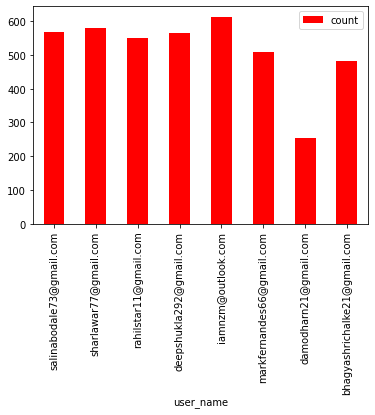

In [12]:
pdf =  df3.toPandas()
pdf.plot.bar(x='user_name', y = 'count', color = 'r')
plt.show()


In [13]:
df3.createOrReplaceTempView("average_sec")

Get average working seconds of users

In [14]:
df4 = spark.sql("select user_name,count,((((count*5)*60)/6)) as avg_sec FROM average_sec")
df4.show()

+--------------------+-----+-------+
|           user_name|count|avg_sec|
+--------------------+-----+-------+
|salinabodale73@gm...|  569|28450.0|
|sharlawar77@gmail...|  580|29000.0|
|rahilstar11@gmail...|  551|27550.0|
|deepshukla292@gma...|  565|28250.0|
|  iamnzm@outlook.com|  614|30700.0|
|markfernandes66@g...|  508|25400.0|
|damodharn21@gmail...|  253|12650.0|
|bhagyashrichalke2...|  482|24100.0|
+--------------------+-----+-------+



In [15]:
from pyspark.sql.functions import *
avg_hour = df4.withColumn("avg_hours",concat(floor(col("avg_sec")/3600), lit(":"),floor(col("avg_sec")%3600/60)))
avg_hour.show()

+--------------------+-----+-------+---------+
|           user_name|count|avg_sec|avg_hours|
+--------------------+-----+-------+---------+
|salinabodale73@gm...|  569|28450.0|     7:54|
|sharlawar77@gmail...|  580|29000.0|      8:3|
|rahilstar11@gmail...|  551|27550.0|     7:39|
|deepshukla292@gma...|  565|28250.0|     7:50|
|  iamnzm@outlook.com|  614|30700.0|     8:31|
|markfernandes66@g...|  508|25400.0|      7:3|
|damodharn21@gmail...|  253|12650.0|     3:30|
|bhagyashrichalke2...|  482|24100.0|     6:41|
+--------------------+-----+-------+---------+



In [16]:
avg_hour.select(f.max("avg_hours").alias("max_avg_hours")).show()

+-------------+
|max_avg_hours|
+-------------+
|         8:31|
+-------------+



In [17]:
avg_hour.select(f.min("avg_hours").alias("min_avg_hours")).show()

+-------------+
|min_avg_hours|
+-------------+
|         3:30|
+-------------+



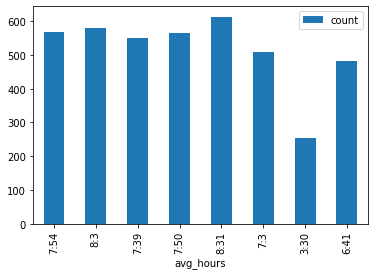

In [18]:
import matplotlib.pyplot as plt
pdf1 =  avg_hour.toPandas()
pdf1.plot.bar(x = 'avg_hours', y = 'count')
plt.show()

In [19]:
df5 = spark.sql("select user_name from working_user_count where keyboard=0 or mouse=0").groupBy("user_name").count()
df5.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  239|
|sharlawar77@gmail...|  178|
|rahilstar11@gmail...|  256|
|deepshukla292@gma...|  256|
|  iamnzm@outlook.com|  259|
|markfernandes66@g...|  235|
|damodharn21@gmail...|  100|
|bhagyashrichalke2...|  159|
+--------------------+-----+



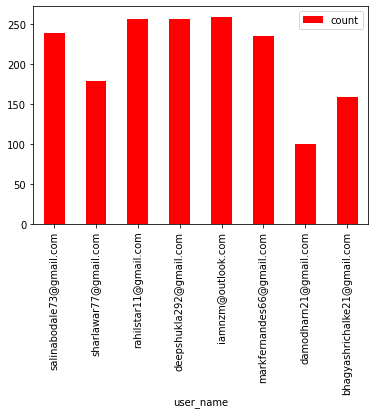

In [20]:
import matplotlib.pyplot as plt
pdf =  df5.toPandas()
pdf.plot.bar(x='user_name', y = 'count', color = 'r')
plt.show()

In [21]:
df5.createOrReplaceTempView("idle_hours")

In [22]:
df6  = spark.sql("select user_name,count,((((count*5)*60)/6)) as avg_sec FROM idle_hours")
df6.show()

+--------------------+-----+-------+
|           user_name|count|avg_sec|
+--------------------+-----+-------+
|salinabodale73@gm...|  239|11950.0|
|sharlawar77@gmail...|  178| 8900.0|
|rahilstar11@gmail...|  256|12800.0|
|deepshukla292@gma...|  256|12800.0|
|  iamnzm@outlook.com|  259|12950.0|
|markfernandes66@g...|  235|11750.0|
|damodharn21@gmail...|  100| 5000.0|
|bhagyashrichalke2...|  159| 7950.0|
+--------------------+-----+-------+



In [23]:
avg_idle_hour = df4.withColumn("avg_idle_hours",concat(floor(col("avg_sec")/3600), lit(":"),floor(col("avg_sec")%3600/60)))
avg_idle_hour.show()

+--------------------+-----+-------+--------------+
|           user_name|count|avg_sec|avg_idle_hours|
+--------------------+-----+-------+--------------+
|salinabodale73@gm...|  569|28450.0|          7:54|
|sharlawar77@gmail...|  580|29000.0|           8:3|
|rahilstar11@gmail...|  551|27550.0|          7:39|
|deepshukla292@gma...|  565|28250.0|          7:50|
|  iamnzm@outlook.com|  614|30700.0|          8:31|
|markfernandes66@g...|  508|25400.0|           7:3|
|damodharn21@gmail...|  253|12650.0|          3:30|
|bhagyashrichalke2...|  482|24100.0|          6:41|
+--------------------+-----+-------+--------------+



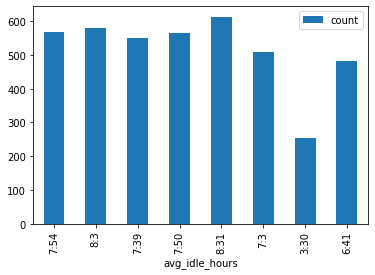

In [24]:
import matplotlib.pyplot as plt
pdf1 =  avg_idle_hour.toPandas()
pdf1.plot.bar(x = 'avg_idle_hours', y = 'count')
plt.show()

In [25]:
avg_idle_hour.select(f.max("avg_idle_hours").alias("max_avg_idle_hours")).show()

+------------------+
|max_avg_idle_hours|
+------------------+
|              8:31|
+------------------+



In [26]:
avg_idle_hour.select(f.min("avg_idle_hours").alias("min_avg_idle_hours")).show()

+------------------+
|min_avg_idle_hours|
+------------------+
|              3:30|
+------------------+



In [ ]:
import os
from dotenv import load_dotenv
load_dotenv('.env')

DATABASE = os.getenv("DATABASE")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
AUTH_PLUGIN = os.getenv("AUTH_PLUGIN")
    

In [ ]:
conn = mysql.connector.connect(
    
)

In [35]:
df3.createOrReplaceTempView("late_user_count")
df3.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



In [36]:
df3.select(f.min("count").alias("late_coming_user")).show()

+----------------+
|late_coming_user|
+----------------+
|             253|
+----------------+

